In [59]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Neural Network Model

In [60]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
        nn.Linear(1,10),
        nn.Sigmoid(),
        nn.Linear(10,1, bias=False)
        )
        
    def forward(self, x):
        N = self.layers(x)
        return N

In [61]:
def training(x, loss_fn, optimizer):
    x = x.to(device)
    def closure():
        loss = loss_fn(x)
        optimizer.zero_grad()
        loss.backward()
        return loss
    optimizer.step(closure)

### Differential equation
$$\frac{d^2\phi(r)}{dr^2} + \frac{2m}{\hbar^2}\left(E-\frac{l(l+1)}{2mr^2}\hbar^2-V(r)\right)\phi(r) = 0$$ 
Dataset are vectors of domain of differential equation, like the vectors are one-dimentional, the shape of dataset is one by m samples. Trial solution $\phi_t(r) = e^{-\beta r^2}N(r,\vec{p})$, with $\phi(r=0) = 0$ and $\phi(r\rightarrow\infty) = 0$ as boundary conditions.  

In [68]:
model = NeuralNetwork().to(device)
model

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=10, out_features=1, bias=False)
  )
)

In [69]:
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.001)
beta = 2
global Z
Z = 1
global e
#e = -1.602e-19
e = -1
global hbar
#hbar = 1.054e-34
hbar = 1
global m
#m = 9.109e-31
m = 1
global l
l = 0
V = lambda r: -(Z*e**2)/r
Phi_t = lambda r: torch.exp(-beta*r**2) * model.forward(r)

In [70]:
def loss_fn(r):
    r.requires_grad = True
    
    outputs = Phi_t(r)
    Phi_t_r = torch.autograd.grad(outputs, r, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    Phi_t_r_r = torch.autograd.grad(Phi_t_r, r, grad_outputs=torch.ones_like(Phi_t_r), create_graph=True)[0]
    H_Phi_t = -(hbar**2/(2*m))*Phi_t_r_r + (l*(l+1)*hbar**2/(2*m*r**2) + V(r))*outputs
    
    prom = outputs.size()[0]
    
    delta = r[1]-r[0]
    norm = torch.sum(outputs**2)*delta
    
    global E
    E = (torch.sum(outputs*H_Phi_t)*delta)/norm
    
    return (torch.mean((H_Phi_t - E*outputs)**2)*prom)/norm #multiply by m to avoit division by m in the mean function of torh 

In [71]:
upper_r = 6
lower_r = 1e-2
steps = 100
R_train = torch.Tensor(np.linspace(lower_r, upper_r, steps)[:,None])
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n ---------------------- loss: {loss_fn(R_train.to(device))}")
    training(R_train, loss_fn, optimizer)
print("Done!")

Epoch 1
 ---------------------- loss: tensor([25526.2246], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 2
 ---------------------- loss: tensor([25304.0605], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 3
 ---------------------- loss: tensor([24975.6641], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 4
 ---------------------- loss: tensor([24367.0371], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 5
 ---------------------- loss: tensor([23569.7461], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 6
 ---------------------- loss: tensor([22767.8965], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 7
 ---------------------- loss: tensor([22004.9453], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 8
 ---------------------- loss: tensor([21158.8789], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 9
 ---------------------- loss: tensor([20024.3223], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 10
 ---------------------- loss: tensor([18653.6406], device='cuda:0', grad_fn=<DivBackward0>)

Epoch 84
 ---------------------- loss: tensor([63.1056], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 85
 ---------------------- loss: tensor([63.0903], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 86
 ---------------------- loss: tensor([63.0770], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 87
 ---------------------- loss: tensor([63.0501], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 88
 ---------------------- loss: tensor([63.0093], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 89
 ---------------------- loss: tensor([62.9817], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 90
 ---------------------- loss: tensor([62.9601], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 91
 ---------------------- loss: tensor([62.9305], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 92
 ---------------------- loss: tensor([62.9068], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 93
 ---------------------- loss: tensor([62.8878], device='cuda:0', grad_fn=<DivBackward0>)
Epoch 94
 ----------

In [72]:
E

tensor([1.0111], device='cuda:0', grad_fn=<DivBackward0>)

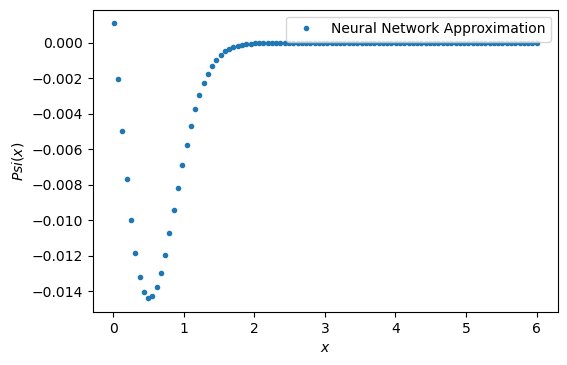

In [73]:
rr = np.linspace(lower_r, upper_r, steps)[:,None]

with torch.no_grad():
    yy = Phi_t(torch.Tensor(rr).to(device)).cpu().numpy()
#yt = xx**2 + np.exp(-xx**2 / 2)/(1+xx+xx**3)

fig, axs = plt.subplots(dpi=100)
#axs.plot(xx, yt, label="True")
axs.plot(rr, yy, ".", label="Neural Network Approximation")
axs.set_xlabel("$x$")
axs.set_ylabel("$Psi(x)$")
plt.legend(loc="best")

In [22]:
R = torch.Tensor(np.ones([steps,steps])*np.reshape(np.linspace(lower_r,upper_r,steps),(1,steps)))
R[0][100:200]

tensor([0.0302, 0.0905, 0.1508, 0.2111, 0.2714, 0.3317, 0.3920, 0.4523, 0.5126,
        0.5729, 0.6332, 0.6935, 0.7538, 0.8141, 0.8744, 0.9347, 0.9950, 1.0553,
        1.1156, 1.1759, 1.2362, 1.2965, 1.3568, 1.4171, 1.4774, 1.5377, 1.5980,
        1.6583, 1.7186, 1.7789, 1.8392, 1.8995, 1.9598, 2.0201, 2.0804, 2.1407,
        2.2010, 2.2613, 2.3216, 2.3819, 2.4422, 2.5025, 2.5628, 2.6231, 2.6834,
        2.7437, 2.8040, 2.8643, 2.9246, 2.9849, 3.0452, 3.1055, 3.1658, 3.2261,
        3.2864, 3.3467, 3.4070, 3.4673, 3.5276, 3.5879, 3.6482, 3.7085, 3.7688,
        3.8291, 3.8894, 3.9497, 4.0101, 4.0704, 4.1307, 4.1910, 4.2513, 4.3116,
        4.3719, 4.4322, 4.4925, 4.5528, 4.6131, 4.6734, 4.7337, 4.7940, 4.8543,
        4.9146, 4.9749, 5.0352, 5.0955, 5.1558, 5.2161, 5.2764, 5.3367, 5.3970,
        5.4573, 5.5176, 5.5779, 5.6382, 5.6985, 5.7588, 5.8191, 5.8794, 5.9397,
        6.0000])

In [20]:
loss_fn(R.to(device))

tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n